# INTRODUCTION

## Background

There is a large amount of data available related to the NBA seasons (prefessional basketball). After the introduction of SportVU cameras in every stadium, we now have the ability to know exactly where all five offensive players and all five defensive players are at every moment of the game.

We also know where every shot is taken. I am interested in understanding where the top players are shooting from. More specifically, I am interested in the spatial distribution of shots taken by each player.

# LOADING and CLEANING DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import sklearn.model_selection
from sklearn.decomposition import NMF

C:\Users\Geoff\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's load the data from the 2013-14 season that I downloaded from https://github.com/hwchase17/sportvu.

I will also remove any unwanted columns and add a column (the shooter's team).

In [2]:
# Load data and keep desired columns
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])

# Add shooter's team column
teamID_dict = plot_court.out_teamsDict()
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']
df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)

## Discretizing the court for binning

Before I start analyzing the data, I must decide how I want to describe each player's spatial distribution of shots.

Instead of just analyzing the raw data, I wanted to use a model to estimate the underlying shot distribution that best describes the outcome. The raw data is sparse and there are a number of locations where a player did not take from. However, just because the player did not shoot from there over the course of the season does not mean that the probability of shooting from that location is zero. A model allows me to smoothen the shot distribution and have non-zero values for locations where no shots were taken (due to sparse sampling).

It is reasonable to model the spatial location of each shot attempt using an inhomogeneous Poisson point process. The Poisson point process is a commonly used statistical model of randomly located points in space. This will help us estimate the average number of expected shots (not an integer) from each location.

------------------------------------------------------------------------

To simplify the problem, I will grid up the court into small boxes and estimate the number of shots in the region defined by the box.

A finer grid is ideal. It will give me a better resolution of the shot distribution. However, a finer grid also requires more computation time to fit the model.

I settled on 25 horizontal rows (along x-axis) and 18 vertical columns (along y-axis). This corresponds to bins that are 2x2 feet areas on the court.

In [3]:
# Number of bins and range in each direction used to make the grid for analysis
bins, binRange = ([25,18], [[-250,250], [-47.5,312.5]])

hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(df.LOC_X, df.LOC_Y, 
                                                                    df.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=bins, 
                                                                    range=binRange)
# Creating the grid we will use for analysis
XX, YY = np.meshgrid(xedges, yedges)
binX_flat = XX.T[:-1,:-1].flatten()
binY_flat = YY.T[:-1,:-1].flatten()
binXY = np.column_stack((binX_flat.T, binY_flat.T))

## Creating training data for players

Let's create a list of the top 100 players in most shots taken during the 2013-14 season.

In [4]:
num_players = 100
top_players_shotNum = df.PLAYER_NAME.value_counts()[:num_players]
top_players_nameList = top_players_shotNum.index.tolist()

Now that I know which players I am including in my study, I want to create a training set for each player. 80% of each of these players' shots are added to the training set, and the other shots are added to a testing set.

We can use the testing set to verify our conclusions later.

In [5]:
train_df = {}
test_df = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = df[df.PLAYER_NAME == player]
    train_df[player], test_df[player] = sklearn.model_selection.train_test_split(temp, test_size = 0.2)

    
player_shotHist_train = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = train_df[player]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=bins, 
                                                                        range=binRange)
    player_shotHist_train[player] = hist2d.flatten()

# LOG-GAUSSIAN COX PROCESS (LGCP) MODEL

## Theory behind the model

As mentioned previously, the spatial location of each shot attempt using an inhomogeneous Poisson point process. 

For each player ($n$), I need to infer the expected number of shots ($\lambda_{n,v}$) taken from each grid point ($v$) on the discretized court. From that, we can get each player's shot profile ($\mathbf{\lambda_n} = [\lambda_{n,1} \dots \lambda_{n,V}]^T$), where $V$ is the number of grid points.

Since we don't know $\mathbf{\lambda_n}$, we will estimate it using likelihood-maximization. 

------------------------------------------

Let's first start by defining some variables, how we obtain them, and how we will use them.

The data we imported and cleaned gives us a count of the number of shots ($X_{n,v}$) in each bin ($v$) for each player ($n$). This player data can be summarized by a flattened 2-dimensional histogram: $\mathbf{x_n} = [X_{n,1} \dots X_{n,V}]^T$.

For a given player shot profile ($\mathbf{\lambda_n}$), the likelihood we see the observed data ($\mathbf{x_n}$) follows a Poisson process:

> ${\displaystyle p(\mathbf{x_n}|\mathbf{\lambda_n}) = \prod_{v=1}^V p(X_{n,v}|\lambda_{n,v}) }$

> ${\displaystyle p(X_{n,v}|\lambda_{n,v}) = e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

where $p(X_{n,v}|\lambda_{n,v})$ is the probability that $X_{n,v}$ shots are taken in area $v$ given that the expected number is $\lambda_{n,v}$. The above equation assumes that each shot is independent.

-----------------------------------------

However, what we are really interested in is the shot profile that maximizes the likelihood of seeing the data. To do this, we turn to Bayes' theorem.

The likelihood of a given shot profile ($\mathbf{\lambda_n}$) explaining the observed data is

> ${\displaystyle p(\mathbf{\lambda_n}|\mathbf{x_n}) \propto p(\mathbf{x_n}|\mathbf{\lambda_n}) p(\mathbf{\lambda_n}) }$

The $\mathbf{\lambda_n}$ that maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$ will gives us the best estimate of each player's shot profile. I already showed how to compute $p(\mathbf{x_n}|\mathbf{\lambda_n})$, but how to compute $p(\mathbf{\lambda_n})$ is less clear.

--------------------------------------------------------

The prior ($p(\mathbf{\lambda_n})$) describes how confident I am in what $\mathbf{\lambda_n}$ should be.

We could set $p(\mathbf{\lambda_n})$ to a constant, which says all values of $\mathbf{\lambda_n}$ are equally likely. For this case, the $\mathbf{\lambda_n}$ that maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$ is simply $\mathbf{\lambda_n} = \mathbf{x_n}$. This is the frequentist approach which is the same as using the raw data instead of fitting a model. This has two undesired properties:

1. $\lambda_{n,v}=0$ in areas where a player didn't shoot from. But just because a player didn't shoot from a certain bin during the season doesn't mean the probability of him shooting from there is zero.

2. $\lambda_{n,v}$ and $\lambda_{n,v'}$ are not correlated, even if bins $v$ and $v'$ are nearby. I don't expect that a player's shooting behavior changes drastically just a few feet away. 

----------------------------------------------------

To solve both issues, we define $p(\mathbf{\lambda_n})$ as

> ${\displaystyle p(\mathbf{\lambda_n}) = p(\mathbf{z_n}) = \mathcal{N}(\mathbf{z_n}|0,\mathbf{K}) }$

> ${\displaystyle \mathbf{\lambda_n} = \exp(z_0 + \mathbf{z_n}) }$

where $z_0$ is a bias term and $\mathcal{N}(\mathbf{z_n}|0,\mathbf{K})$ is a normal distribution over a field variable $\mathbf{z_n}$ with a zero mean and a covariance $\mathbf{K}$.

The covariance matrix ($\mathbf{K}$) captures the correlations between neighboring bins. The closer the bins are, the larger the pair correlation. A simple way to capture this is to use an isotropic function to describe the correlations so they are only a function of the distance between bins (and not whether the bins are left, right, etc. of each other). In this work, $\mathbf{K}$ has elements $K_{i,j}$, where

> ${\displaystyle K_{i,j} = \sigma^2 \exp \left( - \frac{d_{i,j}^2}{2 \phi^2} \right) }$

$d_{i,j}$ is the distance between bins $i$ and $j$, $\phi$ is a length scale, and $\sigma^2$ is the marginal variation. Since $d_{i,j} = d_{j,i}$, $\mathbf{K}$ is a symmetric matrix.

As mentioned previously, the correlation matrix makes $\lambda_{n,v}$ vary smoothly. Bins where a player didn't take shots from will have estimates that are similar to neighboring bins.

-------------------------------------------------


In [6]:
dist_matrix = scipy.spatial.distance_matrix(binXY, binXY)

def cov_func(dist_matrix, sigma2, phi2):
    return sigma2 * np.exp( -(dist_matrix**2) / (2 * phi2) )

I use a large $\sigma^2$ to show that we are not very certain about our inital guess of $\z_{n,v} = 0$ for all bins $v$.

I also set $\phi$ to be 2.5 feet. I just chose this value because it seemed reasonable.

In [7]:
sigma2 = 60.
phi2 = 25.**2

cov_K = cov_func(dist_matrix, sigma2, phi2)
det_cov_K = np.linalg.det(cov_K)
inv_cov_K = np.linalg.inv(cov_K)

## Putting the model into Python

The $\mathbf{\lambda_n}$ that maximizes $\ln [p(\mathbf{\lambda_n}|\mathbf{x_n}) ]$ also maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$. This is convenient because maximizing $\ln [p(\mathbf{\lambda_n}|\mathbf{x_n}) ]$ is computationally cheaper.

So we define the following functions:

In [8]:
def ln_prior(zn_v, det_cov_K, inv_cov_K):
    part1 = -np.log(2 * np.pi * (det_cov_K**0.5))
    part2 = -0.5 * np.dot(zn_v, np.dot(inv_cov_K, zn_v))
    return part1 + part2

def lambdaN_func(z0, zn_v):
    return np.exp(z0 + zn_v)

def ln_lambdaN_func(z0, zn_v):
    return z0 + zn_v

def ln_factorial(n):
    # an improvement of the Sterling Approximation of log(n!)
    # given by Srinivasa Ramanujan (Ramanujan 1988)
    # scipy.misc.factorial stops worknig at large values of n
    sterling = n * np.log(n) - n
    correct = (1./6) * np.log(n * (1 + 4*n*(1 + 2*n))) + np.log(np.pi)/2
    return sterling + correct

def ln_likelihood(z0, zn_v, Xn_v):
    part1 = -lambdaN_func(z0, zn_v)
    part2 = Xn_v * ln_lambdaN_func(z0, zn_v)
    part3 = np.nan_to_num(-ln_factorial(Xn_v))
    #print(np.sum(part1), np.sum(part2), np.sum(part3))
    #print(part3)
    return np.sum(part1 + part2 + part3)

def ln_postprob(z, Xn_v, det_cov_K, inv_cov_K):
    z0 = z[0]
    zn_v = z[1:]
    return ln_prior(zn_v, det_cov_K, inv_cov_K) + ln_likelihood(z0, zn_v, Xn_v)


And to overlay the player's shot profile over the court, I define the following function.

In [21]:
def plot_player_normLambda(player, norm_lambdaN_v, vmax=None):
    LAMBDA_v = np.reshape(norm_lambdaN_v, bins)
    ##########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.imshow(LAMBDA_v.T, cmap=plt.cm.hot_r, alpha=.9, vmax=vmax,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: LGCP'%(player), fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


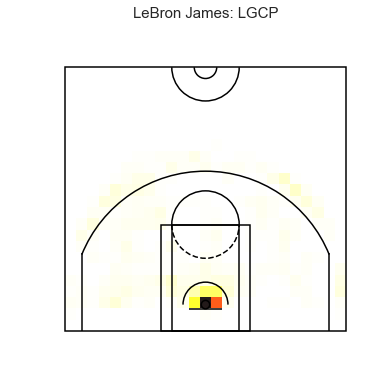

In [22]:
player = 'LeBron James'
#################################################
Xn_v = player_shotHist_train[player]
z0_guess = np.log(np.mean(Xn_v))
zn_v_guess = np.zeros(len(Xn_v))
z_guess = np.append(z0_guess, zn_v_guess)

neg_logLike = lambda *args: -ln_postprob(*args)
result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                 args=(Xn_v, det_cov_K, inv_cov_K))
z_MaxLike = result["x"]
z0_MaxLike = z_MaxLike[0]
zn_MaxLike = z_MaxLike[1:]
lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
   
plot_player_normLambda(player, norm_lambdaN_v)

In [19]:
LL = np.zeros((num_players,np.prod(bins)))
for i, player in enumerate(top_players_nameList):
    try:
        norm_lambdaN_v = np.loadtxt('player_lambda/norm_lambda_%s.txt'%(player))
    except:
        Xn_v = player_shotHist_train[player]
        z0_guess = np.log(np.mean(Xn_v))
        zn_v_guess = np.zeros(len(Xn_v))
        z_guess = np.append(z0_guess, zn_v_guess)
    
        neg_logLike = lambda *args: -ln_postprob(*args)
        result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                         args=(Xn_v, det_cov_K, inv_cov_K))
        z_MaxLike = result["x"]
        z0_MaxLike = z_MaxLike[0]
        zn_MaxLike = z_MaxLike[1:]
        lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
        norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
    
        np.savetxt('player_lambda/norm_lambda_%s.txt'%(player), norm_lambdaN_v)
    LL[i,:] = norm_lambdaN_v[:]

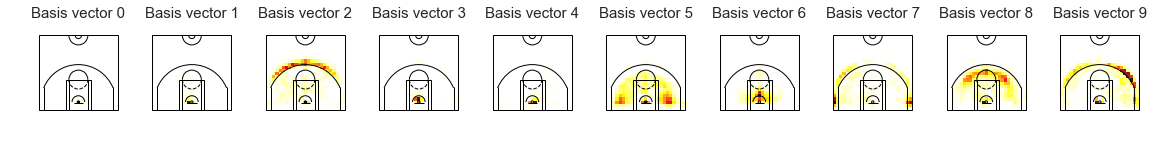

In [12]:
n_comp = 10
model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, solver='cd')
W = model.fit_transform(LL)
H = model.components_    


plt.figure(figsize=(20,14))
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)

    extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

    plt.imshow(H[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.hot_r, alpha=.9,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)

    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

In [13]:
[np.sum(H[i,:]) for i in range(n_comp)]

[1.6153409967854477,
 2.6063180968946011,
 4.787449066944836,
 3.1324194379330388,
 2.4172453554488516,
 5.2886689985830095,
 5.1441635315837573,
 3.9689145453595547,
 4.05952429559132,
 4.7171612953327759]

In [14]:
df_W = pd.DataFrame(W, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
df_W[:3]

,Basis 0,Basis 1,Basis 2,Basis 3,Basis 4,Basis 5,Basis 6,Basis 7,Basis 8,Basis 9
Kevin Durant,0.066163,0.041480,0.083156,0.002457,0.009118,0.033602,0.016643,0.000457,0.022067,0.001288
Carmelo Anthony,0.036336,0.041089,0.037687,0.003066,0.008812,0.065418,0.000000,0.002634,0.030329,0.036983
DeMar DeRozan,0.026676,0.010794,0.000000,0.016261,0.020049,0.056599,0.011118,0.027076,0.068499,0.021633


In [15]:
W_norm = np.copy(W)
H_norm = np.copy(H)
for i in range(n_comp):
    temp = np.sum(H[i,:])
    W_norm[:,i] *= temp
    H_norm[i,:] *= 1./temp
[np.sum(W_norm[i,:]) for i in range(20)]

[1.0036172418818547,
 1.0311164654284293,
 1.0147266922482925,
 1.0605941066842508,
 1.0324289775436557,
 1.0197061045332669,
 1.072441244497367,
 0.9831628726344217,
 1.0299266702298353,
 1.0159067049718211,
 1.0141232286185817,
 0.98996730356549212,
 1.0280077330081769,
 1.0304406994288242,
 0.97244758609672921,
 1.0004883980247825,
 0.97085450432891163,
 0.96485859034567656,
 1.0420333233435266,
 0.99160505770096696]

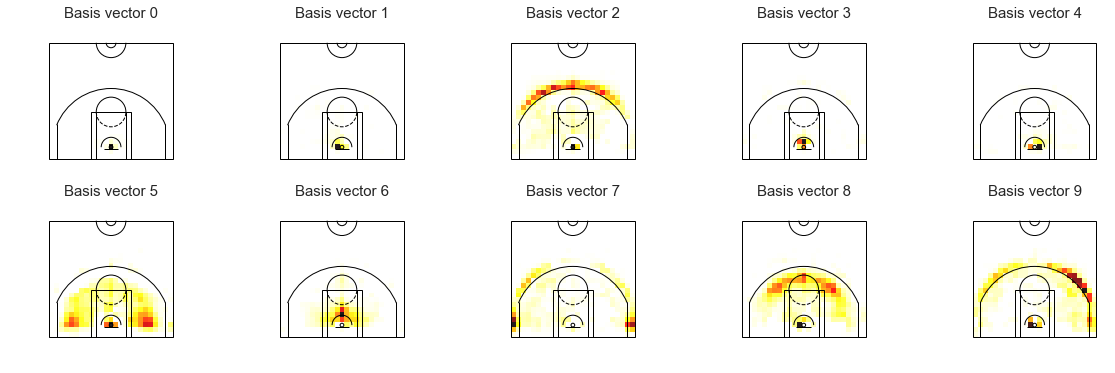

,Basis 0,Basis 1,Basis 2,Basis 3,Basis 4,Basis 5,Basis 6,Basis 7,Basis 8,Basis 9
Kevin Durant,0.106876,0.108109,0.398104,0.007696,0.022041,0.177709,0.085612,0.001814,0.089581,0.006074
Carmelo Anthony,0.058695,0.107091,0.180425,0.009605,0.021300,0.345973,0.000000,0.010455,0.123119,0.174453
DeMar DeRozan,0.043091,0.028133,0.000000,0.050936,0.048464,0.299331,0.057191,0.107463,0.278073,0.102045
Kevin Love,0.132656,0.081453,0.192968,0.032750,0.041660,0.056048,0.122933,0.000000,0.048737,0.351389
LaMarcus Aldridge,0.093609,0.000000,0.000000,0.014655,0.080231,0.284479,0.100293,0.000000,0.447046,0.012116
Blake Griffin,0.125364,0.147918,0.000000,0.221952,0.059802,0.033092,0.104868,0.000000,0.320938,0.005771
Al Jefferson,0.126525,0.035141,0.000000,0.029417,0.118106,0.311292,0.310869,0.000000,0.141091,0.000000
Stephen Curry,0.012882,0.013698,0.430653,0.080405,0.068917,0.000000,0.039996,0.106594,0.223889,0.006128
LeBron James,0.210719,0.189706,0.096127,0.062826,0.074581,0.133176,0.000000,0.023676,0.062471,0.176644
Paul George,0.071648,0.065651,0.234668,0.063370,0.036140,0.206017,0.000000,0.139012,0.098682,0.100718


In [25]:
plt.figure(figsize=(20,6))
for i in range(n_comp):
    plt.subplot(2, np.ceil(n_comp/2.), i+1)

    extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

    plt.imshow(H_norm[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.hot_r, alpha=.9,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)

    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

df_W_norm = pd.DataFrame(W_norm, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
df_W_norm[:20]

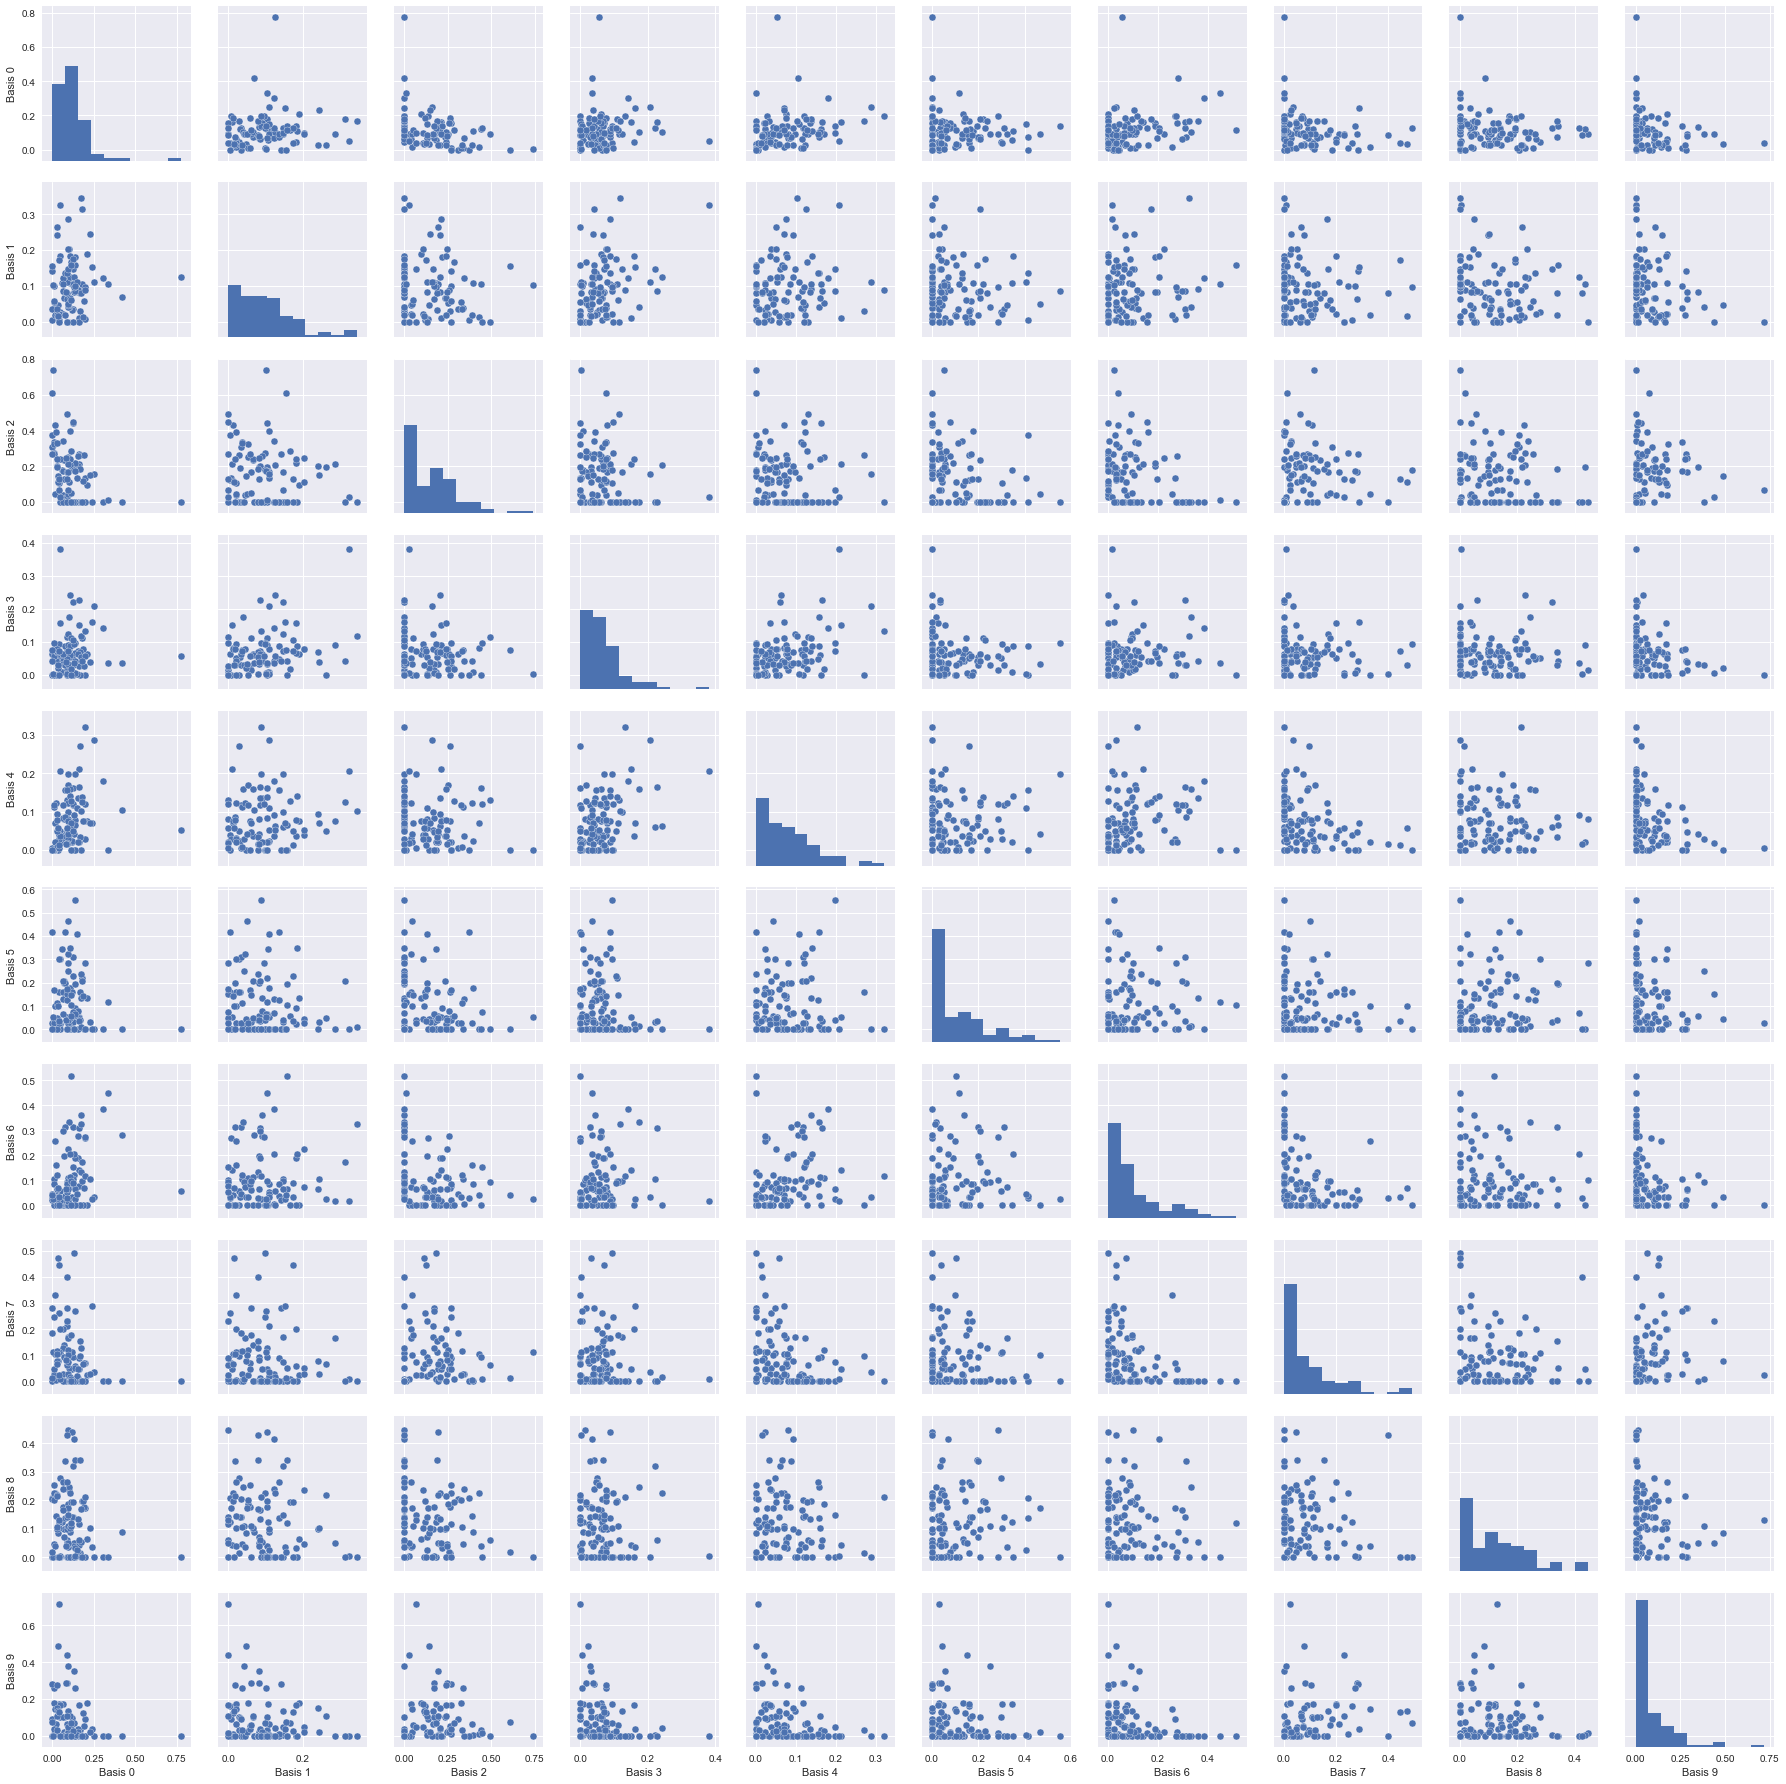

In [17]:
sns.pairplot(df_W_norm, vars=['Basis %d'%i for i in range(n_comp)])
plt.show()